In [3]:
from sklearn import tree, neighbors, svm, neural_network, ensemble, preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve, validation_curve
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt

In [4]:
#Plotting the data from learning algorithm
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Percentage of Training Data")
    plt.ylabel("Error")
    train_scores = []
    test_scores = []
    for i in train_sizes:
        trainX, testX, trainY, testY = train_test_split(X, y, test_size=1 - i)
        estimator.fit(trainX, trainY)
        train_scores.append(1 - estimator.score(trainX, trainY))
        test_scores.append(1 - estimator.score(testX, testY))

    plt.grid()

    plt.plot(train_sizes, train_scores, 'o-', color="r",
             label="Training error")
    plt.plot(train_sizes, test_scores, 'o-', color="g",
             label="Testing error")

    plt.legend(loc="best")
    return plt

#Plotting the data from learning algorithm
def plot_validation_curve(estimator, title, X, y, paramName, paramRange, ylim=None, cv=None,
                          n_jobs=1, special=None):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel(paramName)
    plt.ylabel("error")
    if special == None:
        train_scores, test_scores = validation_curve(
            estimator, X, y, cv=cv, n_jobs=n_jobs, param_name=paramName, param_range=paramRange)
    elif special[0] == 'hidden_layer_sizes':
        newParamRange = paramRange
        paramRange = [x[0] for x in newParamRange]
        train_scores, test_scores = validation_curve(
            estimator, X, y, cv=cv, n_jobs=n_jobs, param_name=paramName, param_range=newParamRange)
    elif special[0] == 'base_estimator':
        newParamRange = paramRange
        paramRange = special[1]
        train_scores, test_scores = validation_curve(
            estimator, X, y, cv=cv, n_jobs=n_jobs, param_name=paramName, param_range=newParamRange)
    else:
        train_scores, test_scores = validation_curve(
            estimator, X, y, cv=cv, n_jobs=n_jobs, param_name=paramName, param_range=paramRange)
    train_scores_mean = 1 - np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = 1 - np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(paramRange, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(paramRange, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(paramRange, train_scores_mean, 'o-', color="r",
             label="Training error")
    plt.plot(paramRange, test_scores_mean, 'o-', color="g",
             label="Cross-validation error")

    plt.legend(loc="best")
    return plt


class HousingPricesDataset:
    def __init__(self):
        self.data = pd.read_csv('datasets/housingPricesDataset.csv')
        self.formatData()

    def formatData(self):
        dropLabels = ['price']
        self.target = self.data.loc[:, 'price']
        self.percentiles = np.percentile(self.target, [10, 20, 30, 40, 50, 60, 70, 80, 90])
        self.data['price'] = self.data['price'].apply(self.categorize)
        self.target = self.data.loc[:, 'price']
        self.data.drop(dropLabels, axis=1, inplace=True)

    def categorize(self, val):
        # print (val, self.percentiles)
        if val < self.percentiles[0]:
            return "10"
        elif val < self.percentiles[1]:
            return "20"
        elif val < self.percentiles[2]:
            return "30"
        elif val < self.percentiles[3]:
            return "40"
        elif val < self.percentiles[4]:
            return "50"
        elif val < self.percentiles[5]:
            return "60"
        elif val < self.percentiles[6]:
            return "70"
        elif val < self.percentiles[7]:
            return "80"
        elif val < self.percentiles[8]:
            return "90"
        else:
            return "100"

    def splitData(self):
        trainX, testX, trainY, testY = train_test_split(self.data, self.target, test_size=0.30)
        return trainX, testX, trainY, testY

    def getData(self):
        return self.data, self.target

    def trainDecisionTree(self, n):
        classifier = self.createDecisionTree(n)
        trainX, testX, trainY, testY = self.splitData()

        classifier.fit(trainX, trainY)
        return classifier.score(trainX, trainY), classifier.score(testX, testY)

    #Pruning done in from of limiting max depth of tree to 5
    def createDecisionTree(self):
        classifier = tree.DecisionTreeClassifier(max_depth=5, min_samples_leaf=91)
        return classifier

    def createKNN(self):
        classifier = neighbors.KNeighborsClassifier(20)  # , weights='distance') #700 best
        return classifier

    def createNN(self):
        classifier = neural_network.MLPClassifier((68, 104))
        return classifier

    def createSVM(self):
        classifier = svm.SVC(kernel='rbf')
        return classifier

    def createADA(self):
        boost = ensemble.AdaBoostClassifier(base_estimator=tree.DecisionTreeClassifier(max_depth=1), n_estimators=120,
                                            learning_rate=0.6)
        return boost

    def trainSVM(self):
        classifier = self.createSVM()
        trainX, testX, trainY, testY = self.splitData()
        classifier.fit(trainX, trainY)
        return classifier.score(trainX, trainY), classifier.score(testX, testY)

    def trainKNN(self, n):
        classifier = self.createKNN(n)
        trainX, testX, trainY, testY = self.splitData()
        classifier.fit(trainX, trainY)
        return classifier.score(trainX, trainY), classifier.score(testX, testY)


def treeCrossValidation(limit):
    d = HousingPricesDataset()

    t = np.arange(1, limit + 1)
    score = []
    for val in t:
        print("Running Tree cross validation for {} max depth".format(val))
        for a in range(1):
            classifier = d.createDecisionTree(val)
            data, target = d.getData()
            val = cross_val_score(classifier, data, target, cv=10)
            score.append(val.mean())
    fig, ax = plt.subplots()
    ax.plot(t, np.array(score))
    ax.set(xlabel='max depth', ylabel='accuracy',
           title='max depth vs accuracy')
    plt.ylim(0, 1)
    ax.grid()
    print(max(score))
    plt.show()


def treeTrainTest(limit):
    d = HousingPricesDataset()

    t = np.arange(1, limit + 1)
    trainVals = []
    testVals = []
    for val in t:
        print("Running Tree train test for {} max depth".format(val))
        one = np.array([])
        two = np.array([])
        for a in range(1):
            train, test = d.trainDecisionTree(val)
            one = np.append(one, train)
            two = np.append(two, test)
        trainVals.append(one.mean())
        testVals.append(two.mean())

    fig, ax = plt.subplots()
    ax.plot(t, np.array(trainVals))
    ax.plot(t, np.array(testVals))
    ax.set(xlabel='max depth', ylabel='accuracy',
           title='max depth vs accuracy')
    plt.ylim(0, 1.1)
    print(max(trainVals), max(testVals))
    ax.grid()
    plt.show()


def KNNTrainTest(limit):
    d = HousingPricesDataset()

    t = np.arange(1, limit + 1)
    trainVals = []
    testVals = []
    for val in t:
        print("Running KNN train test for {} neighbors".format(val))
        one = np.array([])
        two = np.array([])
        for a in range(1):
            train, test = d.trainKNN(val)
            print(train, test)
            one = np.append(one, train)
            two = np.append(two, test)
        trainVals.append(one.mean())
        testVals.append(two.mean())

    fig, ax = plt.subplots()
    ax.plot(t, np.array(trainVals))
    ax.plot(t, np.array(testVals))
    ax.set(xlabel='max depth', ylabel='accuracy',
           title='max depth vs accuracy')
    plt.ylim(0, 1.1)
    ax.grid()
    plt.show()


def KNNCrossValidation(limit):
    d = HousingPricesDataset()

    t = np.arange(500, 800, 50)
    score = []
    for val in t:
        print("Running KNN cross validation for {} neighbors".format(val))
        for a in range(1):
            classifier = d.createKNN(val)
            data, target = d.getData()
            val = cross_val_score(classifier, data, y=target, cv=10)
            print (val)
            print(val.mean())
            score.append(val.mean())

    fig, ax = plt.subplots()
    ax.plot(t, np.array(score))
    ax.set(xlabel='num neighbors', ylabel='accuracy',
           title='num neighbors vs accuracy')
    plt.ylim(0, 1)
    ax.grid()
    print(max(score))
    plt.show()


def SVMCrossValidation():
    d = HousingPricesDataset()
    score = []

    classifier = d.createSVM()
    data, target = d.getData()
    val = cross_val_score(classifier, data, target, cv=5, verbose=10, n_jobs=6)
    print("Average: {}".format(val.mean()))


def NNCrossValidation():
    d = HousingPricesDataset()
    score = []

    classifier = d.createNN()
    data, target = d.getData()
    val = cross_val_score(classifier, data, target, cv=10, verbose=10, n_jobs=-1)
    print("Average: {}".format(val.mean()))


def SVMTrainTest():
    d = HousingPricesDataset()
    score = []
    train, test = d.trainSVM()
    print(train, test)


def gridSearchTree():
    d = HousingPricesDataset()
    dtree = tree.DecisionTreeClassifier()
    grid = {
        'max_depth': [x for x in range(6, 11)],
        'min_samples_leaf': [i for i in range(100, 120, 1)]
    }
    search = GridSearchCV(cv=10, estimator=dtree, param_grid=grid, verbose=10)
    data, target = d.getData()
    search.fit(data, target)
    print(search.best_params_)
    return (search.best_params_, search.best_score_)


def gridSearchKNN():
    d = HousingPricesDataset()
    dtree = neighbors.KNeighborsClassifier()
    grid = {
        'n_neighbors': [x for x in range(180, 300, 10)]  # 181
    }
    search = GridSearchCV(cv=10, estimator=dtree, param_grid=grid, verbose=10, n_jobs=5)
    data, target = d.getData()
    search.fit(data, target)
    print(search.best_params_)
    return (search.best_params_, search.best_score_)

    '''
    NORMALIZE DATA TO -1, 1 FOR SVM
    '''


def gridSearchSVM():
    d = HousingPricesDataset()
    dtree = svm.SVC()
    grid = {
        'gamma': ['auto'] + [i for i in np.arange(0.1, 0.9, 0.1)]
    }
    search = GridSearchCV(cv=5, estimator=dtree, param_grid=grid, verbose=10, n_jobs=6)
    data, target = d.getData()
    data = preprocessing.scale(data)
    search.fit(data, target)
    print(search.best_params_)
    return (search.best_params_, search.best_score_)


def gridSearchNN():
    d = HousingPricesDataset()
    nn = neural_network.MLPClassifier()
    grid = {
        'hidden_layer_sizes': [(x, y) for x in range(65, 76, 1) for y in range(95, 106, 1)]
    }
    search = GridSearchCV(cv=10, estimator=nn, param_grid=grid, verbose=10)
    data, target = d.getData()
    search.fit(data, target)
    print(search.best_params_)
    return (search.best_params_, search.best_score_)


def gridSearchADA():
    d = HousingPricesDataset()
    nn = ensemble.AdaBoostClassifier()
    grid = {
        'n_estimators': [x for x in range(10, 150, 10)],
        'learning_rate': [i for i in np.arange(0.2, 2, 0.2)]
    }
    search = GridSearchCV(cv=10, estimator=nn, param_grid=grid, verbose=10)
    data, target = d.getData()
    search.fit(data, target)
    print(search.best_params_)
    return (search.best_params_, search.best_score_)


def learningCurve(type):
    d = HousingPricesDataset()
    data, target = d.getData()
    if type == 'tree':
        c = d.createDecisionTree()
        plot_learning_curve(c, 'Decision Tree Learning Curve', data, target,
                            train_sizes=([y for y in np.arange(0.01, .1, 0.01)] + [z for z in np.arange(.1, 1, 0.1)]))
        plt.show()
    elif type == 'nn':
        c = d.createNN()
        plot_learning_curve(c, 'Neural Network Learning Curve', data, target,
                            train_sizes=([y for y in np.arange(0.01, .1, 0.01)] + [z for z in np.arange(.1, 1, 0.1)]))
        plt.show()
    elif type == 'boost':
        c = d.createADA()
        plot_learning_curve(c, 'ADABoost Learning Curve', data, target,
                            train_sizes=([y for y in np.arange(0.01, .1, 0.01)] + [z for z in np.arange(.1, 1, 0.1)]))
        plt.show()
    elif type == 'svm':
        knn = d.createSVM()
        svmdata = preprocessing.scale(data)
        plot_learning_curve(knn, 'SVM Learning Curve', svmdata, target,
                            train_sizes=([y for y in np.arange(0.01, .1, 0.01)] + [z for z in np.arange(.1, 1, 0.1)]))
        plt.show()
    elif type == 'knn':
        c = d.createKNN()
        plot_learning_curve(c, 'KNN Learning Curve', data, target,
                            train_sizes=([y for y in np.arange(0.01, .1, 0.01)] + [z for z in np.arange(.1, 1, 0.1)]))
        plt.show()


def valCurve(type, paramName, paramRange, special=None):
    d = HousingPricesDataset()
    data, target = d.getData()
    if type == 'tree':
        c = d.createDecisionTree()
        plot_validation_curve(c, 'Decision Tree Validation Curve', data, target, cv=10, paramName=paramName,
                              paramRange=paramRange)
        plt.show()
    elif type == 'nn':
        c = d.createNN()
        plot_validation_curve(c, 'Neural Network Validation Curve', data, target, cv=10, paramName=paramName,
                              paramRange=paramRange, special=(paramName,))
        plt.show()
    elif type == 'boost':
        c = d.createADA()
        if paramName == 'base_estimator':
            plot_validation_curve(c, 'Decision Tree Validation Curve', data, target, cv=10, paramName=paramName,
                                  paramRange=paramRange, special=(paramName, special))
        else:
            plot_validation_curve(c, 'ADABoost Validation Curve', data, target, cv=10, paramName=paramName,
                                  paramRange=paramRange)
        plt.show()
    elif type == 'svm':
        c = d.createSVM()
        svmdata = preprocessing.scale(data)
        plot_validation_curve(c, 'SVM Tree Validation Curve', svmdata, target, cv=3, paramName=paramName,
                              paramRange=paramRange)
        plt.show()
    elif type == 'knn':
        c = d.createKNN()
        plot_validation_curve(c, 'KNN Validation Curve', data, target, cv=10, paramName=paramName,
                              paramRange=paramRange)
        plt.show()

# learningCurve('knn')

# valCurve('nn', 'hidden_layer_sizes', [(x,104) for x in range(10, 101, 10)])
# valCurve('boost', 'base_estimator', [tree.DecisionTreeClassifier(max_depth=x) for x in range(1, 6, 1)], special=[i for i in range(1,6,1)])
# valCurve('boost', 'learning_rate', [x for x in np.arange(0.2, 2.1, .2)])
# valCurve('svm', 'gamma', [1/9]+[x for x in np.arange(0.2, 2.1, .2)])
# valCurve('knn', 'n_neighbors', [1] + [i for i in range(20, 201, 20)])

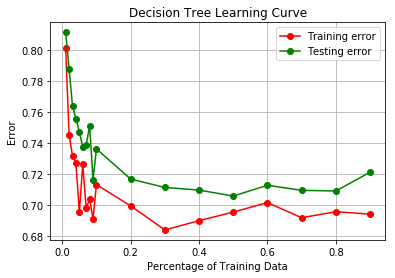

In [16]:
learningCurve('tree')

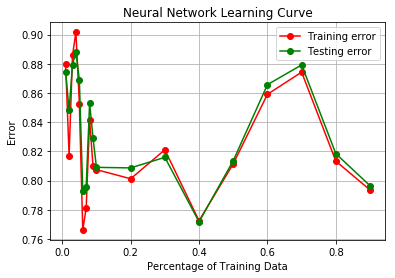

In [6]:
learningCurve('nn')

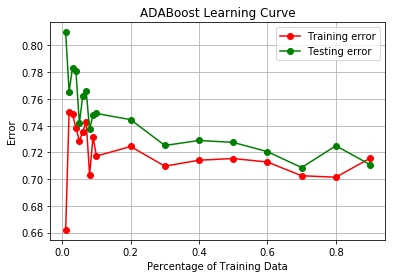

In [18]:
learningCurve('boost')

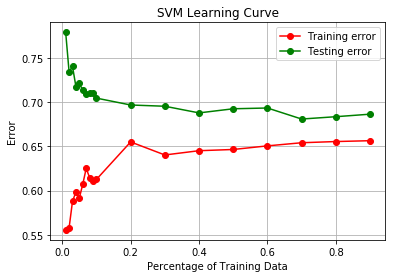

In [19]:
learningCurve('svm')

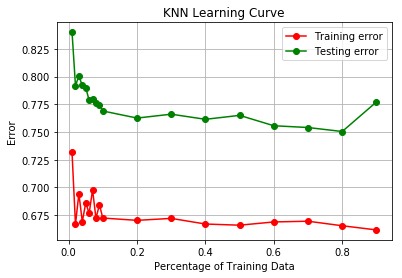

In [20]:
learningCurve('knn')

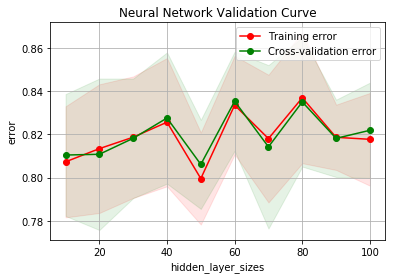

In [21]:
valCurve('nn', 'hidden_layer_sizes', [(x,104) for x in range(10, 101, 10)])

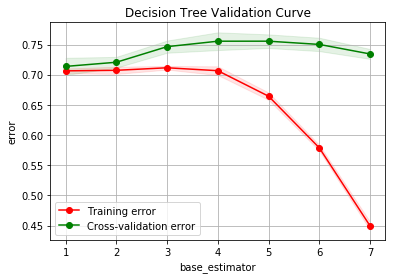

In [22]:
valCurve('boost', 'base_estimator', [tree.DecisionTreeClassifier(max_depth=x) for x in range(1, 8, 1)], special=[i for i in range(1,8,1)])

KeyboardInterrupt: 

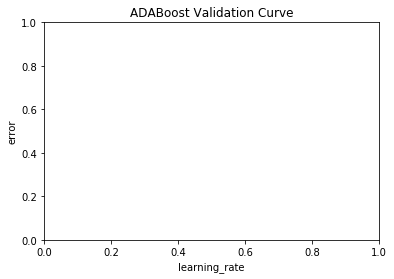

In [23]:
valCurve('boost', 'learning_rate', [x for x in np.arange(0.2, 2.1, .2)])

KeyboardInterrupt: 

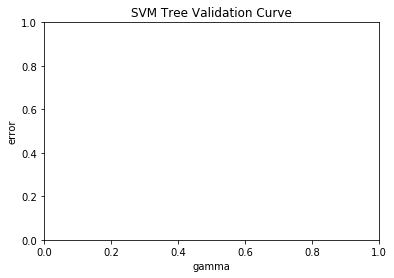

In [24]:
valCurve('svm', 'gamma', [1/9]+[x for x in np.arange(0.2, 2.1, .2)])

KeyboardInterrupt: 

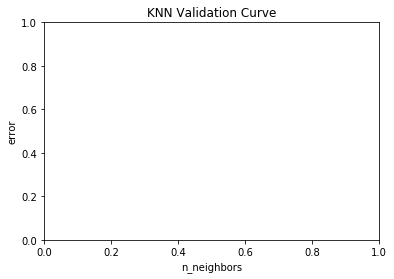

In [25]:
valCurve('knn', 'n_neighbors', [1] + [i for i in range(20, 201, 20)])